In [1]:
from PIL import Image
from pathlib import Path
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import os
from os.path import isfile, join
import random

import numpy as np
import torch
import torchvision

from torchvision import transforms
from tqdm import tqdm

In [6]:
class BaseLine:
    def __init__(self):
        import torch
        import torchvision
        self.input_images_path = 'drive/My Drive/AML2020/images'
        self.csv = 'drive/My Drive/AML2020/train.csv'
        
        self.input_path = 'drive/My Drive/AML2020'
        self.train_path = 'drive/My Drive/AML2020/train'
        self.test_path = 'drive/My Drive/AML2020/test'
        self.valid_path = 'drive/My Drive/AML2020/validation'

    
    def folder_generator(self):
        import pandas as pd
        import logging as log
        import os
        
        csv_labels = pd.read_csv(self.csv)
        
        #images_paths = list(csv_labels['file'])
        images_paths = csv_labels['file']
        images_paths = [path.replace('images/', '') for path in images_paths]
        
        #images_labels = list(csv_labels['is_tiger'])
        images_labels = csv_labels['is_tiger']
        counter = 1
        
        tiger_path_train = os.path.join(self.train_path, 'tiger')
        tiger1_path_train = os.path.join(self.train_path, 'tiger1')
        tiger2_path_train = os.path.join(self.train_path, 'tiger2')
        tiger3_path_train = os.path.join(self.train_path, 'tiger3')
        tiger4_path_train = os.path.join(self.train_path, 'tiger4')
        not_tiger_path_train = os.path.join(self.train_path, 'not_tiger')

        
        tiger_path_val = os.path.join(self.valid_path, 'tiger')
        not_tiger_path_val = os.path.join(self.valid_path, 'not_tiger')
        
        test_unknown_path = os.path.join(self.test_path, 'unknown')
        
        os.mkdir(self.train_path)
        os.mkdir(tiger_path_train)
        os.mkdir(not_tiger_path_train)

        os.mkdir(self.valid_path)
        os.mkdir(tiger_path_val)
        os.mkdir(not_tiger_path_val)
        
        os.mkdir(self.test_path)
        os.mkdir(test_unknown_path)
        
        #Handling Train Images
        print('###Handling Train Images')
        for image_name, image_label in zip(images_paths, images_labels):
            print('Copying image: {}, with label: {}'.format(image_name, image_label))    
            if image_name.split('_')[0] == 'train' and counter % 5 != 0:
                if image_label == 1:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(tiger_path_train, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, tiger_path_train))
                else:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(not_tiger_path_train, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, not_tiger_path_train))
            else:
                if image_label == 1:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(tiger_path_val, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, tiger_path_val))
                else:
                    source_dir = os.path.join(self.input_images_path, image_name) 
                    dest_dir = os.path.join(not_tiger_path_val, image_name)
                    shutil.copy(source_dir, dest_dir)
                    counter += 1
                    print('Copied image: {} to {}'.format(image_name, not_tiger_path_val))
            
        #Handling Test Images
        #print('###Handling Test Images')
        #list_of_images = os.listdir(self.input_images_path)
        #for image_name in list_of_images:
            #if image_name.split('_')[0] == 'test':
        #        source_dir = os.path.join(self.input_images_path, image_name) 
        #        dest_dir = os.path.join(test_unknown_path, image_name)
         #       shutil.copy(source_dir, dest_dir)
          #      print('Copied image: {} to {}'.format(image_name, test_unknown_path))
           #           
        #print('Number of All train images: {}'.format(len(os.listdir(tiger_path_train)) + len(os.listdir(not_tiger_path_train))))
        #print('Number of All validation images: {}'.format(len(os.listdir(tiger_path_val)) + len(os.listdir(not_tiger_path_val))))
        
        #print('Number of All test images: {}'.format(len(os.listdir(self.test_path))))
        
        #print('Tiger Labels: {}'.format(len([label for label in images_labels if label == 1])))
        #print('NotTiger Labels: {}'.format(len([label for label in images_labels if label != 1])))
    
    def data_loader(self, train_data):
        import torch
        import torchvision
        from torchvision import transforms
        #ImageFolder
        #Augementation for train and valid images
        train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            #transforms.Grayscale(num_output_channels=3),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        val_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(), 
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        #train_dataset = torchvision.datasets.ImageFolder(self.train_path, train_transforms)
        train_dataset = torchvision.datasets.ImageFolder(train_data, train_transforms)
        validation_dataset = torchvision.datasets.ImageFolder(self.valid_path, val_transforms)
        
        #DataLoader
        batch_size = 16
        train_dataloader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size
        )

        validation_dataloader = torch.utils.data.DataLoader(
            validation_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size
        )
        print(len(train_dataset), len(validation_dataset))
        print(len(train_dataloader), len(validation_dataloader))
        return train_dataloader, validation_dataloader
    
    def show_images(self, train_dataloader):
        import numpy as np
        import matplotlib.pyplot as plt
        X_batch, y_batch = next(iter(train_dataloader))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([[0.229, 0.224, 0.225]])
        for index in range(5):
            plt.title(y_batch[index])
            plt.imshow(X_batch[index].permute(1,2,0).numpy() * std + mean, )
            plt.show()
    
    def model(self):
        from torchvision import models
        import torch
        model = models.resnet152(pretrained=True)
        
        #Disable grad for all conv layers
        for param in model.parameters():
            param.requires_grad = False 

        model.fc = torch.nn.Linear(model.fc.in_features, 2)
        #model.fc = self.sigmoid = ()
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model.to(device)
        
        loss = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(),amsgrad=True, lr=1.0e-3)
       
        
        #Declay LR by a factor of 0.1 every 5th epoch
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)
        return model, loss, optimizer, scheduler, device
    
    def train_model(self, model, loss, optimizer, scheduler, train, validation, device, num_epochs):
        import torch
        from tqdm import tqdm
        for epoch in range(num_epochs):
            print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    dataloader = train
                    scheduler.step()
                    
                    model.train()  # Set model to training mode
                else:
                    dataloader = validation
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.
                running_acc = 0.
                running_acc_tiger = 0.
                running_acc_not_tiger = 0.

                # Iterate over data.
                for inputs, labels in tqdm(dataloader):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    # forward and backward
                    with torch.set_grad_enabled(phase == 'train'):
                        preds = model(inputs)
                        loss_value = loss(preds, labels)
                        preds_class = preds.argmax(dim=1)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss_value.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss_value.item()
                    running_acc += (preds_class == labels.data).float().mean()
                    running_acc_tiger += (preds_class == 1).float().mean()
                    running_acc_not_tiger += (preds_class == 0).float().mean()

                epoch_loss = running_loss / len(dataloader)
                epoch_acc = running_acc / len(dataloader)
                epoch_acc_tiger = running_acc_tiger / len(dataloader)
                epoch_acc_not_tiger = running_acc_not_tiger / len(dataloader)

                print('{} Loss: {:.4f} Acc: {:.4f} Tiger Acc: {:.4f} Not Tiger Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_acc_tiger, epoch_acc_not_tiger), flush=True)

        return model

    
    def run(self):
        #Processing data
        Job = BaseLine()
        #Job.folder_generator()
        train_dataloader, validation_dataloader = Job.data_loader('drive/My Drive/AML2020/train')
        train_dataloader1, validation_dataloader1 = Job.data_loader('drive/My Drive/AML2020/train1')
        train_dataloader2, validation_dataloader2 = Job.data_loader('drive/My Drive/AML2020/train2')
        train_dataloader3, validation_dataloader3 = Job.data_loader('drive/My Drive/AML2020/train3')
        train_dataloader4, validation_dataloader4 = Job.data_loader('drive/My Drive/AML2020/train4')
        Job.show_images(train_dataloader)
        
        #Define model
        model, loss, optimizer, scheduler, device = Job.model()
        #print(model, loss, optimizer, scheduler)
        #Train model 
        trained_model = Job.train_model(model, loss, optimizer, scheduler, train_dataloader, validation_dataloader, device, num_epochs=7)
        trained_model1 = Job.train_model(model, loss, optimizer, scheduler, train_dataloader1, validation_dataloader1, device, num_epochs=7)
        trained_model2 = Job.train_model(model, loss, optimizer, scheduler, train_dataloader2, validation_dataloader2, device, num_epochs=7)
        trained_model3 = Job.train_model(model, loss, optimizer, scheduler, train_dataloader3, validation_dataloader3, device, num_epochs=7)
        trained_model4 = Job.train_model(model, loss, optimizer, scheduler, train_dataloader4, validation_dataloader4, device, num_epochs=7)
        return trained_model, trained_model1, trained_model2, trained_model3, trained_model4
        #return trained_model

1136 855
71 54
1132 855
71 54
1132 855
71 54
1132 855
71 54
1132 855
71 54


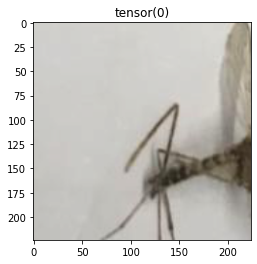

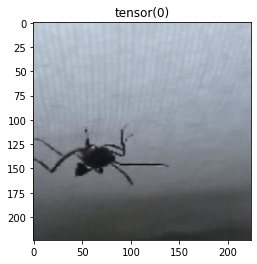

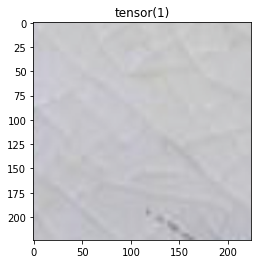

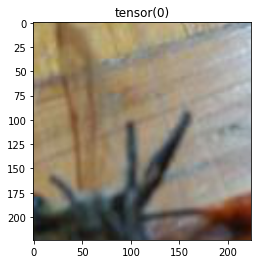

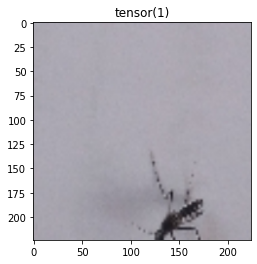

Epoch 0/6:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 71/71 [00:11<00:00,  6.02it/s]

train Loss: 0.5799 Acc: 0.6893 Tiger Acc: 0.5308 Not Tiger Acc: 0.4692



100%|██████████| 54/54 [00:09<00:00,  5.82it/s]

val Loss: 0.2937 Acc: 0.9028 Tiger Acc: 0.8727 Not Tiger Acc: 0.1273
Epoch 1/6:



100%|██████████| 71/71 [00:11<00:00,  6.00it/s]

train Loss: 0.4726 Acc: 0.7685 Tiger Acc: 0.5132 Not Tiger Acc: 0.4868



100%|██████████| 54/54 [00:08<00:00,  6.02it/s]

val Loss: 0.4950 Acc: 0.7717 Tiger Acc: 0.6305 Not Tiger Acc: 0.3695
Epoch 2/6:



100%|██████████| 71/71 [00:11<00:00,  6.05it/s]

train Loss: 0.4419 Acc: 0.7870 Tiger Acc: 0.5018 Not Tiger Acc: 0.4982



100%|██████████| 54/54 [00:08<00:00,  6.05it/s]

val Loss: 0.6555 Acc: 0.6677 Tiger Acc: 0.5180 Not Tiger Acc: 0.4820
Epoch 3/6:



100%|██████████| 71/71 [00:11<00:00,  6.06it/s]

train Loss: 0.4214 Acc: 0.7861 Tiger Acc: 0.5026 Not Tiger Acc: 0.4974



100%|██████████| 54/54 [00:09<00:00,  5.95it/s]

val Loss: 0.3173 Acc: 0.8492 Tiger Acc: 0.7612 Not Tiger Acc: 0.2388
Epoch 4/6:



100%|██████████| 71/71 [00:11<00:00,  5.94it/s]

train Loss: 0.4063 Acc: 0.8213 Tiger Acc: 0.5202 Not Tiger Acc: 0.4798



100%|██████████| 54/54 [00:09<00:00,  5.99it/s]

val Loss: 0.3947 Acc: 0.8203 Tiger Acc: 0.6999 Not Tiger Acc: 0.3001
Epoch 5/6:



100%|██████████| 71/71 [00:12<00:00,  5.60it/s]

train Loss: 0.3912 Acc: 0.8301 Tiger Acc: 0.5097 Not Tiger Acc: 0.4903



100%|██████████| 54/54 [00:10<00:00,  5.06it/s]

val Loss: 0.3578 Acc: 0.8368 Tiger Acc: 0.7303 Not Tiger Acc: 0.2697
Epoch 6/6:



100%|██████████| 71/71 [00:13<00:00,  5.23it/s]

train Loss: 0.3832 Acc: 0.8257 Tiger Acc: 0.5070 Not Tiger Acc: 0.4930



100%|██████████| 54/54 [00:08<00:00,  6.02it/s]

val Loss: 0.3570 Acc: 0.8376 Tiger Acc: 0.7297 Not Tiger Acc: 0.2703
Epoch 0/6:



100%|██████████| 71/71 [00:43<00:00,  1.62it/s]

train Loss: 0.3974 Acc: 0.8019 Tiger Acc: 0.5047 Not Tiger Acc: 0.4953



100%|██████████| 54/54 [00:09<00:00,  5.85it/s]

val Loss: 0.3938 Acc: 0.8284 Tiger Acc: 0.6973 Not Tiger Acc: 0.3027
Epoch 1/6:



100%|██████████| 71/71 [00:12<00:00,  5.86it/s]

train Loss: 0.4026 Acc: 0.8192 Tiger Acc: 0.5109 Not Tiger Acc: 0.4891



100%|██████████| 54/54 [00:09<00:00,  5.91it/s]

val Loss: 0.3288 Acc: 0.8480 Tiger Acc: 0.7439 Not Tiger Acc: 0.2561
Epoch 2/6:



100%|██████████| 71/71 [00:11<00:00,  6.10it/s]

train Loss: 0.3809 Acc: 0.8360 Tiger Acc: 0.4968 Not Tiger Acc: 0.5032



100%|██████████| 54/54 [00:08<00:00,  6.02it/s]

val Loss: 0.3586 Acc: 0.8307 Tiger Acc: 0.7173 Not Tiger Acc: 0.2827
Epoch 3/6:



100%|██████████| 71/71 [00:11<00:00,  6.16it/s]

train Loss: 0.3928 Acc: 0.8237 Tiger Acc: 0.5088 Not Tiger Acc: 0.4912



100%|██████████| 54/54 [00:09<00:00,  5.92it/s]

val Loss: 0.3389 Acc: 0.8414 Tiger Acc: 0.7389 Not Tiger Acc: 0.2611
Epoch 4/6:



100%|██████████| 71/71 [00:11<00:00,  6.03it/s]

train Loss: 0.3809 Acc: 0.8319 Tiger Acc: 0.5032 Not Tiger Acc: 0.4968



100%|██████████| 54/54 [00:09<00:00,  5.97it/s]

val Loss: 0.3529 Acc: 0.8396 Tiger Acc: 0.7340 Not Tiger Acc: 0.2660
Epoch 5/6:



100%|██████████| 71/71 [00:11<00:00,  6.03it/s]

train Loss: 0.3777 Acc: 0.8351 Tiger Acc: 0.4947 Not Tiger Acc: 0.5053



100%|██████████| 54/54 [00:09<00:00,  5.95it/s]

val Loss: 0.3293 Acc: 0.8431 Tiger Acc: 0.7482 Not Tiger Acc: 0.2518
Epoch 6/6:



100%|██████████| 71/71 [00:11<00:00,  6.12it/s]

train Loss: 0.3903 Acc: 0.8237 Tiger Acc: 0.4962 Not Tiger Acc: 0.5038



100%|██████████| 54/54 [00:08<00:00,  6.12it/s]

val Loss: 0.3204 Acc: 0.8484 Tiger Acc: 0.7497 Not Tiger Acc: 0.2503
Epoch 0/6:



100%|██████████| 71/71 [00:43<00:00,  1.62it/s]

train Loss: 0.4120 Acc: 0.8093 Tiger Acc: 0.5056 Not Tiger Acc: 0.4944



100%|██████████| 54/54 [00:09<00:00,  5.95it/s]

val Loss: 0.3240 Acc: 0.8500 Tiger Acc: 0.7521 Not Tiger Acc: 0.2479
Epoch 1/6:



100%|██████████| 71/71 [00:11<00:00,  5.93it/s]

train Loss: 0.3823 Acc: 0.8248 Tiger Acc: 0.4994 Not Tiger Acc: 0.5006



100%|██████████| 54/54 [00:09<00:00,  5.97it/s]

val Loss: 0.3273 Acc: 0.8504 Tiger Acc: 0.7531 Not Tiger Acc: 0.2469
Epoch 2/6:



100%|██████████| 71/71 [00:11<00:00,  6.11it/s]

train Loss: 0.3979 Acc: 0.8099 Tiger Acc: 0.5044 Not Tiger Acc: 0.4956



100%|██████████| 54/54 [00:08<00:00,  6.04it/s]

val Loss: 0.3396 Acc: 0.8492 Tiger Acc: 0.7482 Not Tiger Acc: 0.2518
Epoch 3/6:



100%|██████████| 71/71 [00:11<00:00,  6.07it/s]

train Loss: 0.3792 Acc: 0.8190 Tiger Acc: 0.4977 Not Tiger Acc: 0.5023



100%|██████████| 54/54 [00:08<00:00,  6.00it/s]

val Loss: 0.3340 Acc: 0.8438 Tiger Acc: 0.7397 Not Tiger Acc: 0.2603
Epoch 4/6:



100%|██████████| 71/71 [00:11<00:00,  6.04it/s]

train Loss: 0.3874 Acc: 0.8304 Tiger Acc: 0.4965 Not Tiger Acc: 0.5035



100%|██████████| 54/54 [00:08<00:00,  6.09it/s]

val Loss: 0.3530 Acc: 0.8388 Tiger Acc: 0.7308 Not Tiger Acc: 0.2692
Epoch 5/6:



100%|██████████| 71/71 [00:11<00:00,  6.12it/s]

train Loss: 0.3819 Acc: 0.8283 Tiger Acc: 0.4900 Not Tiger Acc: 0.5100



100%|██████████| 54/54 [00:08<00:00,  6.03it/s]

val Loss: 0.3573 Acc: 0.8376 Tiger Acc: 0.7335 Not Tiger Acc: 0.2665
Epoch 6/6:



100%|██████████| 71/71 [00:11<00:00,  6.03it/s]

train Loss: 0.4016 Acc: 0.8128 Tiger Acc: 0.5035 Not Tiger Acc: 0.4965



100%|██████████| 54/54 [00:08<00:00,  6.06it/s]

val Loss: 0.3805 Acc: 0.8246 Tiger Acc: 0.7050 Not Tiger Acc: 0.2950
Epoch 0/6:



100%|██████████| 71/71 [00:42<00:00,  1.67it/s]

train Loss: 0.3872 Acc: 0.8239 Tiger Acc: 0.4921 Not Tiger Acc: 0.5079



100%|██████████| 54/54 [00:09<00:00,  5.97it/s]

val Loss: 0.3360 Acc: 0.8411 Tiger Acc: 0.7440 Not Tiger Acc: 0.2560
Epoch 1/6:



100%|██████████| 71/71 [00:11<00:00,  5.94it/s]

train Loss: 0.3898 Acc: 0.8289 Tiger Acc: 0.5015 Not Tiger Acc: 0.4985



100%|██████████| 54/54 [00:09<00:00,  5.90it/s]

val Loss: 0.3399 Acc: 0.8396 Tiger Acc: 0.7386 Not Tiger Acc: 0.2614
Epoch 2/6:



100%|██████████| 71/71 [00:11<00:00,  6.07it/s]

train Loss: 0.3836 Acc: 0.8242 Tiger Acc: 0.4962 Not Tiger Acc: 0.5038



100%|██████████| 54/54 [00:09<00:00,  5.99it/s]

val Loss: 0.3129 Acc: 0.8562 Tiger Acc: 0.7644 Not Tiger Acc: 0.2356
Epoch 3/6:



100%|██████████| 71/71 [00:11<00:00,  6.08it/s]

train Loss: 0.3690 Acc: 0.8371 Tiger Acc: 0.5097 Not Tiger Acc: 0.4903



100%|██████████| 54/54 [00:08<00:00,  6.04it/s]

val Loss: 0.3444 Acc: 0.8376 Tiger Acc: 0.7297 Not Tiger Acc: 0.2703
Epoch 4/6:



100%|██████████| 71/71 [00:11<00:00,  5.97it/s]

train Loss: 0.3773 Acc: 0.8316 Tiger Acc: 0.4953 Not Tiger Acc: 0.5047



100%|██████████| 54/54 [00:09<00:00,  5.98it/s]

val Loss: 0.2883 Acc: 0.8666 Tiger Acc: 0.7670 Not Tiger Acc: 0.2330
Epoch 5/6:



100%|██████████| 71/71 [00:11<00:00,  6.04it/s]

train Loss: 0.3964 Acc: 0.8213 Tiger Acc: 0.4953 Not Tiger Acc: 0.5047



100%|██████████| 54/54 [00:08<00:00,  6.07it/s]

val Loss: 0.3809 Acc: 0.8295 Tiger Acc: 0.7045 Not Tiger Acc: 0.2955
Epoch 6/6:



100%|██████████| 71/71 [00:11<00:00,  6.08it/s]

train Loss: 0.3784 Acc: 0.8342 Tiger Acc: 0.5106 Not Tiger Acc: 0.4894



100%|██████████| 54/54 [00:09<00:00,  5.97it/s]

val Loss: 0.3543 Acc: 0.8299 Tiger Acc: 0.7227 Not Tiger Acc: 0.2773
Epoch 0/6:



100%|██████████| 71/71 [00:43<00:00,  1.63it/s]

train Loss: 0.3770 Acc: 0.8377 Tiger Acc: 0.4909 Not Tiger Acc: 0.5091



100%|██████████| 54/54 [00:09<00:00,  5.89it/s]

val Loss: 0.3398 Acc: 0.8428 Tiger Acc: 0.7354 Not Tiger Acc: 0.2646
Epoch 1/6:



100%|██████████| 71/71 [00:12<00:00,  5.89it/s]

train Loss: 0.4008 Acc: 0.8237 Tiger Acc: 0.4818 Not Tiger Acc: 0.5182



100%|██████████| 54/54 [00:09<00:00,  5.87it/s]

val Loss: 0.3414 Acc: 0.8469 Tiger Acc: 0.7381 Not Tiger Acc: 0.2619
Epoch 2/6:



100%|██████████| 71/71 [00:11<00:00,  6.05it/s]

train Loss: 0.3842 Acc: 0.8289 Tiger Acc: 0.5021 Not Tiger Acc: 0.4979



100%|██████████| 54/54 [00:09<00:00,  5.98it/s]

val Loss: 0.3094 Acc: 0.8581 Tiger Acc: 0.7571 Not Tiger Acc: 0.2429
Epoch 3/6:



100%|██████████| 71/71 [00:11<00:00,  6.11it/s]

train Loss: 0.4033 Acc: 0.8028 Tiger Acc: 0.4994 Not Tiger Acc: 0.5006



100%|██████████| 54/54 [00:09<00:00,  5.94it/s]

val Loss: 0.3180 Acc: 0.8472 Tiger Acc: 0.7531 Not Tiger Acc: 0.2469
Epoch 4/6:



100%|██████████| 71/71 [00:11<00:00,  5.98it/s]

train Loss: 0.3946 Acc: 0.8327 Tiger Acc: 0.5073 Not Tiger Acc: 0.4927



100%|██████████| 54/54 [00:09<00:00,  5.90it/s]

val Loss: 0.3370 Acc: 0.8426 Tiger Acc: 0.7361 Not Tiger Acc: 0.2639
Epoch 5/6:



100%|██████████| 71/71 [00:11<00:00,  6.00it/s]

train Loss: 0.3788 Acc: 0.8281 Tiger Acc: 0.5009 Not Tiger Acc: 0.4991



100%|██████████| 54/54 [00:09<00:00,  5.88it/s]

val Loss: 0.3085 Acc: 0.8669 Tiger Acc: 0.7720 Not Tiger Acc: 0.2280
Epoch 6/6:



100%|██████████| 71/71 [00:11<00:00,  5.98it/s]

train Loss: 0.3938 Acc: 0.8110 Tiger Acc: 0.4909 Not Tiger Acc: 0.5091



100%|██████████| 54/54 [00:09<00:00,  5.99it/s]

val Loss: 0.3263 Acc: 0.8416 Tiger Acc: 0.7482 Not Tiger Acc: 0.2518


In [7]:
model = BaseLine().run()

In [ ]:
os.mkdir('drive/My Drive/AML2020/train/tiger1')
os.mkdir('drive/My Drive/AML2020/train/tiger2')
os.mkdir('drive/My Drive/AML2020/train/tiger3')
os.mkdir('drive/My Drive/AML2020/train/tiger4')





list = os.listdir('drive/My Drive/AML2020/train/tiger') # dir is your directory path
number_files = int(len(list)*.2)

# list all files in dir
files = [f for f in os.listdir('drive/My Drive/AML2020/train/tiger') if isfile(join('drive/My Drive/AML2020/train/tiger', f))]

# select 0.2 of the files randomly 
random_files1 = np.random.choice(files, number_files , replace=False)

for file_name in random_files1:
    shutil.move(os.path.join('drive/My Drive/AML2020/train/tiger', file_name), 'drive/My Drive/AML2020/train/tiger1')

files = [f for f in os.listdir('drive/My Drive/AML2020/train/tiger') if isfile(join('drive/My Drive/AML2020/train/tiger', f))]
random_files2 = np.random.choice(files, number_files , replace=False)

for file_name in random_files2:
    shutil.move(os.path.join('drive/My Drive/AML2020/train/tiger', file_name), 'drive/My Drive/AML2020/train/tiger2')

files = [f for f in os.listdir('drive/My Drive/AML2020/train/tiger') if isfile(join('drive/My Drive/AML2020/train/tiger', f))]
random_files3 = np.random.choice(files, number_files , replace=False)

for file_name in random_files3:
    shutil.move(os.path.join('drive/My Drive/AML2020/train/tiger', file_name), 'drive/My Drive/AML2020/train/tiger3')

files = [f for f in os.listdir('drive/My Drive/AML2020/train/tiger') if isfile(join('drive/My Drive/AML2020/train/tiger', f))]
random_files4 = np.random.choice(files, number_files , replace=False)

for file_name in random_files4:
    shutil.move(os.path.join('drive/My Drive/AML2020/train/tiger', file_name), 'drive/My Drive/AML2020/train/tiger4')  



In [ ]:
os.mkdir('drive/My Drive/AML2020/train1')
os.mkdir('drive/My Drive/AML2020/train2')
os.mkdir('drive/My Drive/AML2020/train3')
os.mkdir('drive/My Drive/AML2020/train4')
os.mkdir('drive/My Drive/AML2020/train1/not_tiger')
os.mkdir('drive/My Drive/AML2020/train2/not_tiger')
os.mkdir('drive/My Drive/AML2020/train3/not_tiger')
os.mkdir('drive/My Drive/AML2020/train4/not_tiger')

import os, shutil
def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

copytree('drive/My Drive/AML2020/train/not_tiger', 'drive/My Drive/AML2020/train1/not_tiger')
copytree('drive/My Drive/AML2020/train/not_tiger', 'drive/My Drive/AML2020/train2/not_tiger')
copytree('drive/My Drive/AML2020/train/not_tiger', 'drive/My Drive/AML2020/train3/not_tiger')
copytree('drive/My Drive/AML2020/train/not_tiger', 'drive/My Drive/AML2020/train4/not_tiger')
shutil.move('drive/My Drive/AML2020/train/tiger1', 'drive/My Drive/AML2020/train1')
shutil.move('drive/My Drive/AML2020/train/tiger2', 'drive/My Drive/AML2020/train2')
shutil.move('drive/My Drive/AML2020/train/tiger3', 'drive/My Drive/AML2020/train3')
shutil.move('drive/My Drive/AML2020/train/tiger4', 'drive/My Drive/AML2020/train4')






'drive/My Drive/AML2020/train4/tiger4'

In [ ]:
random_files
len(random_files) != len(set(random_files))

False

In [ ]:
list = os.listdir('drive/My Drive/AML2020/train/tiger') # dir is your directory path
number_files = int(len(list))
number_files

576

In [ ]:
import os

list = os.listdir('drive/My Drive/AML2020/train/tiger') # dir is your directory path
number_files = len(list)
print (number_files)

list = os.listdir('drive/My Drive/AML2020/train/tiger1') # dir is your directory path
number_files = len(list)
print (number_files)

list = os.listdir('drive/My Drive/AML2020/train/tiger2') # dir is your directory path
number_files = len(list)
print (number_files)

list = os.listdir('drive/My Drive/AML2020/train/tiger3') # dir is your directory path
number_files = len(list)
print (number_files)

list = os.listdir('drive/My Drive/AML2020/train/tiger4') # dir is your directory path
number_files = len(list)
print (number_files)



576
572
572
572
572


In [ ]:

train_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Grayscale(num_output_channels=3),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
train_dataset = torchvision.datasets.ImageFolder('drive/My Drive/AML2020/train', train_transforms)

data = torch.utils.data.DataLoader(
            train_dataset, batch_size=16, shuffle=True, num_workers=16
        )
dir(data)

['_DataLoader__initialized',
 '_DataLoader__multiprocessing_context',
 '_IterableDataset_len_called',
 '__abstractmethods__',
 '__annotations__',
 '__args__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__extra__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next_in_mro__',
 '__orig_bases__',
 '__origin__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__tree_hash__',
 '__weakref__',
 '_abc_cache',
 '_abc_generic_negative_cache',
 '_abc_generic_negative_cache_version',
 '_abc_registry',
 '_auto_collation',
 '_dataset_kind',
 '_get_iterator',
 '_gorg',
 '_index_sampler',
 '_iterator',
 'batch_sampler',
 'batch_size',
 'collate_fn',
 'dataset',
 'drop_last',
 'generator',
 'multiprocessing_context',
 'num_w

In [ ]:
print()

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
model.fc.sigm = torch.nn.Sigmoid()
model.fc.linear == 0
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 